In [3]:
import numpy as np
import torch
import torch.nn as nn

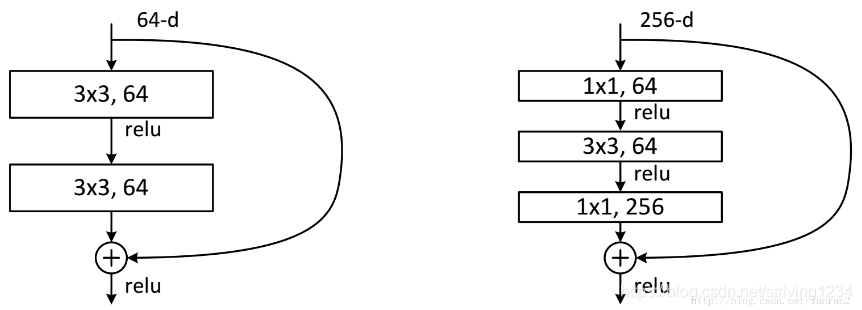

In [6]:
import torch
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, i_downsample=None):
        super(Block, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels)
        )

        self.relu = nn.ReLU()
        self.stride = stride
        self.i_downsample = i_downsample
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.conv2(x)
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        print(x.shape)
        print(identity.shape)
        x += identity
        x = self.relu(x)
        return x


In [7]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, i_downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, 1, 0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels * 4, 1, 1, 0),
            nn.BatchNorm2d(out_channels * 4)
        )
        self.relu = nn.ReLU()
        self.i_downsample = i_downsample
        self.stride = stride
        self.bn = nn.BatchNorm2d(out_channels * 4)

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

In [8]:
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(image_channels, 64, 7, 2, 3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2_x = self._make_layer(block, layers[0], out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3_x = self._make_layer(block, layers[1], out_channels=128, kernel_size=3, stride=2, padding=1)
        self.conv4_x = self._make_layer(block, layers[2], out_channels=256, kernel_size=3, stride=2, padding=1)
        self.conv5_x = self._make_layer(block, layers[3], out_channels=512, kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def _make_layer(self, block, num_residual_blocks, out_channels, kernel_size, stride, padding):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels * 4)
            )

        layers.append(block(self.in_channels, out_channels, kernel_size, stride, padding, identity_downsample))
        self.in_channels = out_channels * 4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels, kernel_size, stride, padding))
        return nn.Sequential(*layers)

In [12]:
class ResNet18(ResNet):
    def __init__(self, channels=3,num_classes=1000):
        super().__init__(Block, [2, 2, 2, 2],channels, num_classes)

model=ResNet18()
print(model)

ResNet18(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2_x): Sequential(
    (0): Block(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
      (i_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )


In [13]:
class ResNet34(ResNet):
    def __init__(self, channels=3,num_classes=1000):
        super().__init__(Block, [3, 4, 6, 3],channels, num_classes)

model=ResNet34()
print(model)

ResNet34(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2_x): Sequential(
    (0): Block(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
      (i_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
